In [ ]:
Ref: https://scenicplus.readthedocs.io/en/latest/_modules/scenicplus/eregulon_enrichment.html

# Post-process after running Scenic plus

In [1]:
import os
import sys
import pickle
import dill
import tempfile

import logging as log

import warnings
warnings.simplefilter(action = 'ignore')

from pathlib import Path

import numpy as np
import scanpy as sc
import anndata


import pandas
import pyranges
import pybiomart as pbm

from scenicplus.scenicplus_class import create_SCENICPLUS_object
from scenicplus.wrappers.run_scenicplus import run_scenicplus
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks
from scenicplus.RSS import *
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from pycisTopic.diff_features import find_highly_variable_features

import networkx as nx
import json

from IPython.display import display, Markdown

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.set_figure_params(dpi=150, frameon=False, figsize=(10, 10), facecolor='white')

In [9]:
import importlib.util
import sys
# spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/regulon.py")
spec = importlib.util.spec_from_file_location("module.name", "/home/jovyan/data_for_outage/function/python/regulon.py")
regulon = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = regulon
spec.loader.exec_module(regulon)

# spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
spec = importlib.util.spec_from_file_location("module.name", "/home/jovyan/data_for_outage/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

# Functions

# Parameters

In [6]:
celltype = 'Cardiomyocytes'
celltype_column = 'coarse_grain'
target_type = 'gene' # gene or region
query_adata_path = '/nfs/team205/heart/anndata_objects/Foetal/trisomy21/AtlasT21IntegratedRaw.h5ad'

# Load eRegulon signatures

In [11]:
target_type_mod = target_type[0].upper() + target_type[1:]
eRegulon_signatures = utils.read_pkl(f'/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/{celltype}_{target_type_mod}_eRegulon_signatures.pkl')

# Prepare query data

In [14]:
adata = sc.read_h5ad(query_adata_path)

# subset celltype
adata = adata[adata.obs[celltype_column]==celltype]

# subset multiome
adata = adata[adata.obs['kit_10x']=='Multiome-v1']

# log-normalise
# shouldn't matter whether raw or normalised, need to check
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print(adata.X.data[:10])
adata

[0.41374123 0.22811745 0.22811745 0.41374123 0.22811745 0.41374123
 0.22811745 0.41374123 0.22811745 0.22811745]


AnnData object with n_obs × n_vars = 85617 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'MidGrainModified', 'leiden', 'original_or_new', 'age_days', 'diagnosis', 'batch', 'cell_type', 'scANVI_predictions', 'coarse_predi

In [15]:
adata.obs['kit_10x'].value_counts()

Multiome-v1    85617
Name: kit_10x, dtype: int64

# Score eRegulons

In [16]:
%%time
adata.obsm[f'eRegulon_score_{target_type}'] = regulon.score_eRegulons_mod(adata,
                                                eRegulon_signatures,
                                                # enrichment_type=target_type,
                                                use_rep = 'X',
                                                auc_threshold=0.05,
                                                normalize=False,
                                                n_cpu=1,
                                                seed= 123
                                                 ).reindex(adata.obs_names)

100%|██████████| 374/374 [05:24<00:00,  1.15it/s]


CPU times: user 13min 8s, sys: 39.7 s, total: 13min 48s
Wall time: 13min 48s


In [17]:
adata.obsm[f'eRegulon_score_{target_type}']

AHCTF1_extended_+_(291g)  \
barcode                                                                            
BHF_F_Hea11064670_BHF_F_Hea11031823_TTGCTTAGTGAGACTC-1                  0.033035   
BHF_F_Hea11064670_BHF_F_Hea11031823_GTACACCCATCCCTCA-1                  0.043631   
BHF_F_Hea11064670_BHF_F_Hea11031823_GGTCGGTTCTTAGGAC-1                  0.054142   
BHF_F_Hea11064670_BHF_F_Hea11031823_CGATCCTTCTTGTCCA-1                  0.038706   
BHF_F_Hea11064670_BHF_F_Hea11031823_GCTCAACCAGGCTGTT-1                  0.063272   
...                                                                          ...   
BHF_F_Hea13188327_BHF_F_Hea13187629_AGCTAGTTCTAACCAA-1                  0.043303   
BHF_F_Hea13188327_BHF_F_Hea13187629_ACAGCCGGTCTCAGCC-1                  0.049426   
BHF_F_Hea13188327_BHF_F_Hea13187629_CGATTTGCAGCTAACC-1                  0.044467   
BHF_F_Hea13188327_BHF_F_Hea13187629_TGCCGGTAGGATGATG-1                  0.029690   
BHF_F_Hea13188327_BHF_F_Hea13187629_TGATGATGTTTACGTC-1                  0.034135   

                                                        ARID3A_+_(1426g)  \
barcode                                                                    
BHF_F_Hea11064670_BHF_F_Hea11031823_TTGCTTAGTGAGACTC-1          0.046529   
BHF_F_Hea11064670_BHF_F_Hea11031823_GTACACCCATCCCTCA-1          0.059707   
BHF_F_Hea11064670_BHF_F_Hea11031823_GGTCGGTTCTTAGGAC-1          0.040900   
BHF_F_Hea11064670_BHF_F_Hea11031823_CGATCCTTCTTGTCCA-1          0.038358   
BHF_F_Hea11064670_BHF_F_Hea11031823_GCTCAACCAGGCTGTT-1          0.052566   
...                                                                  ...   
BHF_F_Hea13188327_BHF_F_Hea13187629_AGCTAGTTCTAACCAA-1          0.027690   
BHF_F_Hea13188327_BHF_F_Hea13187629_ACAGCCGGTCTCAGCC-1          0.044312   
BHF_F_Hea13188327_BHF_F_Hea13187629_CGATTTGCAGCTAACC-1          0.028566   
BHF_F_Hea13188327_BHF_F_Hea13187629_TGCCGGTAGGATGATG-1          0.032813   
BHF_F_Hea13188327_BHF_F_Hea13187629_TGATGATGTTTACGTC-1          0.026990   

                                                        ARID5A_extended_+_(18g)  \
barcode                                                                           
BHF_F_Hea11064670_BHF_F_Hea11031823_TTGCTTAGTGAGACTC-1                 0.114086   
BHF_F_Hea11064670_BHF_F_Hea11031823_GTACACCCATCCCTCA-1                 0.083455   
BHF_F_Hea11064670_BHF_F_Hea11031823_GGTCGGTTCTTAGGAC-1                 0.068792   
BHF_F_Hea11064670_BHF_F_Hea11031823_CGATCCTTCTTGTCCA-1                 0.074347   
BHF_F_Hea11064670_BHF_F_Hea11031823_GCTCAACCAGGCTGTT-1                 0.084912   
...                                                                         ...   
BHF_F_Hea13188327_BHF_F_Hea13187629_AGCTAGTTCTAACCAA-1                 0.097116   
BHF_F_Hea13188327_BHF_F_Hea13187629_ACAGCCGGTCTCAGCC-1                 0.134123   
BHF_F_Hea13188327_BHF_F_Hea13187629_CGATTTGCAGCTAACC-1                 0.147632   
BHF_F_Hea13188327_BHF_F_Hea13187629_TGCCGGTAGGATGATG-1                 0.085732   
BHF_F_Hea13188327_BHF_F_Hea13187629_TGATGATGTTTACGTC-1                 0.080298   

                                                        ATF1_+_(554g)  \
barcode                                                                 
BHF_F_Hea11064670_BHF_F_Hea11031823_TTGCTTAGTGAGACTC-1       0.136766   
BHF_F_Hea11064670_BHF_F_Hea11031823_GTACACCCATCCCTCA-1       0.092236   
BHF_F_Hea11064670_BHF_F_Hea11031823_GGTCGGTTCTTAGGAC-1       0.126114   
BHF_F_Hea11064670_BHF_F_Hea11031823_CGATCCTTCTTGTCCA-1       0.111676   
BHF_F_Hea11064670_BHF_F_Hea11031823_GCTCAACCAGGCTGTT-1       0.111240   
...                                                               ...   
BHF_F_Hea13188327_BHF_F_Hea13187629_AGCTAGTTCTAACCAA-1       0.078456   
BHF_F_Hea13188327_BHF_F_Hea13187629_ACAGCCGGTCTCAGCC-1       0.066606   
BHF_F_Hea13188327_BHF_F_Hea13187629_CGATTTGCAGCTAACC-1       0.067354   
BHF_F_Hea13188327_BHF_F_Hea13187629_TGCCGGTAGGATGATG-1       0.060476   
BHF_F_Hea13188327_

# Save

In [18]:
adata.obsm[f'eRegulon_score_{target_type}'].to_csv(f'/nfs/team205/heart/pyscenic/plus/AUCscore/T21-Healthy_{celltype}_eRegulon_AUC_{target_type}.csv')

# Differential regulons

In [19]:
# make anndata of AUC score
adata_reg = anndata.AnnData(
    X = adata.obsm[f'eRegulon_score_{target_type}'],
    obs = adata.obs,
    var = pd.DataFrame(adata.obsm[f'eRegulon_score_{target_type}'].columns).set_index(0)
)
adata_reg

AnnData object with n_obs × n_vars = 85617 × 374
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'MidGrainModified', 'leiden', 'original_or_new', 'age_days', 'diagnosis', 'batch', 'cell_type', 'scANVI_predictions', 'coarse_predict

In [20]:
adata_reg.obs['fine_grain_integrated'].value_counts()

VentricularCardiomyocytesLeftCompact          16747
VentricularCardiomyocytesRightCompact         16708
AtrialCardiomyocytesLeft                      12870
AtrialCardiomyocytesRight                     10889
VentricularCardiomyocytesLeftTrabeculated      7648
VentricularCardiomyocytesCycling               7532
VentricularCardiomyocytesRightTrabeculated     4889
AtrialCardiomyocytesCycling                    2952
VentricularConductionSystemProximal            2207
AtrioventricularNodeCardiomyocytes             1142
SinoatrialNodeCardiomyocytes                    994
VentricularConductionSystemDistal               982
background                                       23
MyocardialInterstitialFibroblasts1               12
MyocardialInterstitialFibroblasts2                4
Myofibroblasts                                    3
Megakaryocytes                                    2
ValveInterstitialCells                            2
EndocardialCushionCells                           2
MacrophagesA

In [22]:
adata_reg_sub = adata_reg[adata_reg.obs['fine_grain_integrated']=='VentricularCardiomyocytesLeftCompact']
print(adata_reg_sub.obs['diagnosis'].value_counts())
sc.tl.rank_genes_groups(adata_reg_sub,groupby='diagnosis',method='t-test')

Atlas    13176
T21       3571
Name: diagnosis, dtype: int64


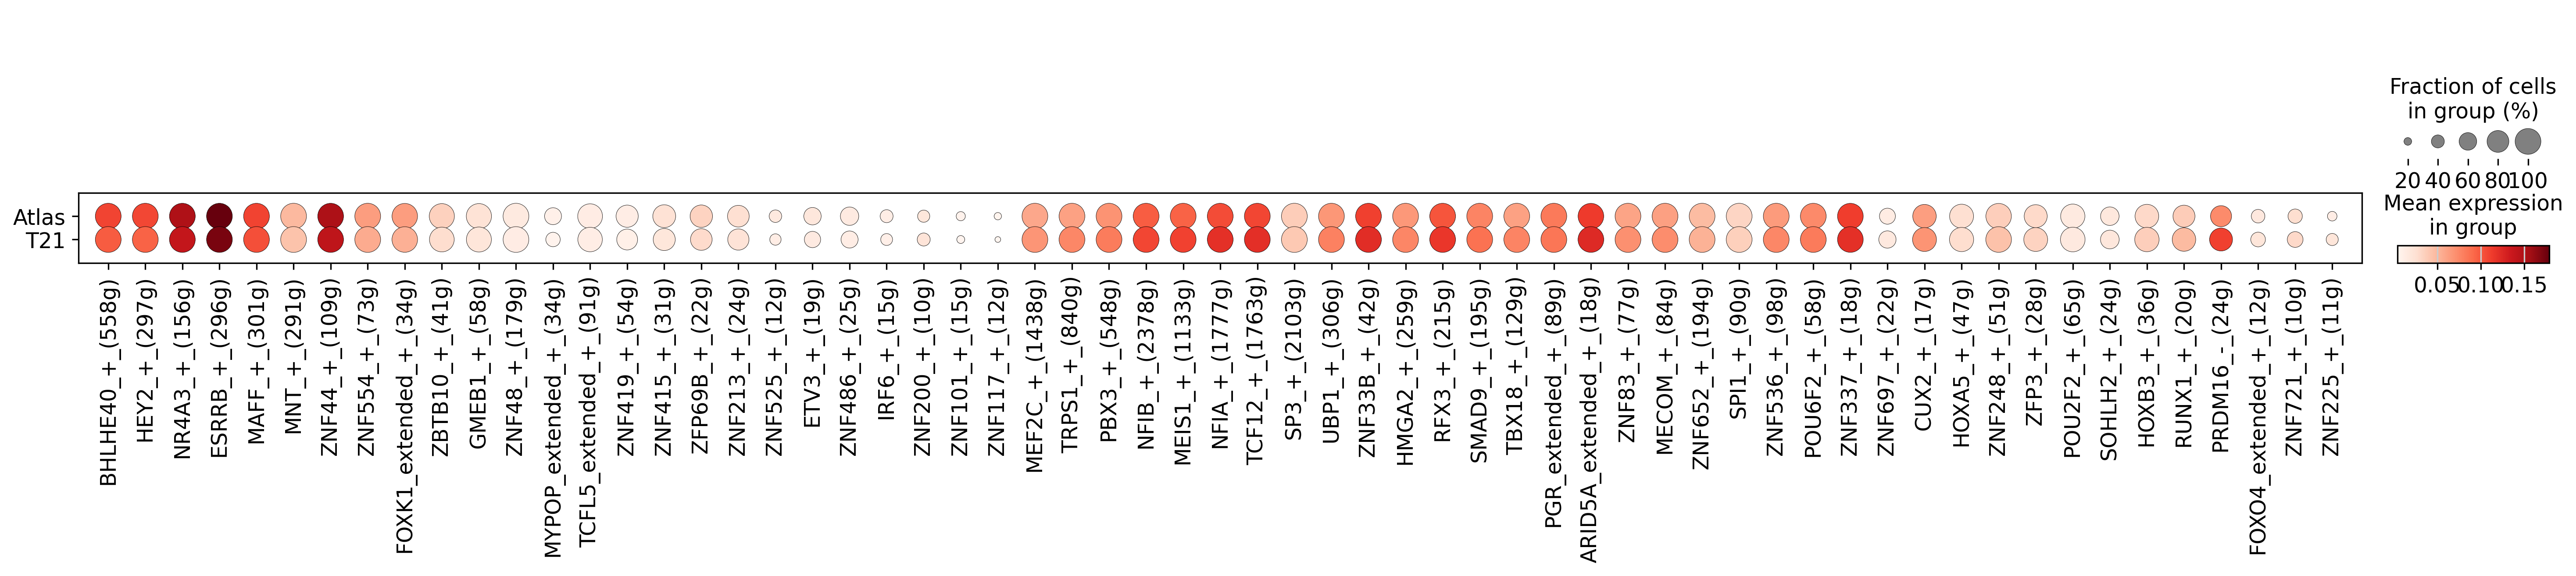

In [27]:
df = sc.get.rank_genes_groups_df(adata_reg_sub,
                            group=None,
                           pval_cutoff=0.1,
                           log2fc_min=0.2)

sc.pl.dotplot(adata_reg,
              df.names.unique(),
                                groupby='diagnosis',
                                dendrogram=False,
                               # standard_scale='var'
             )

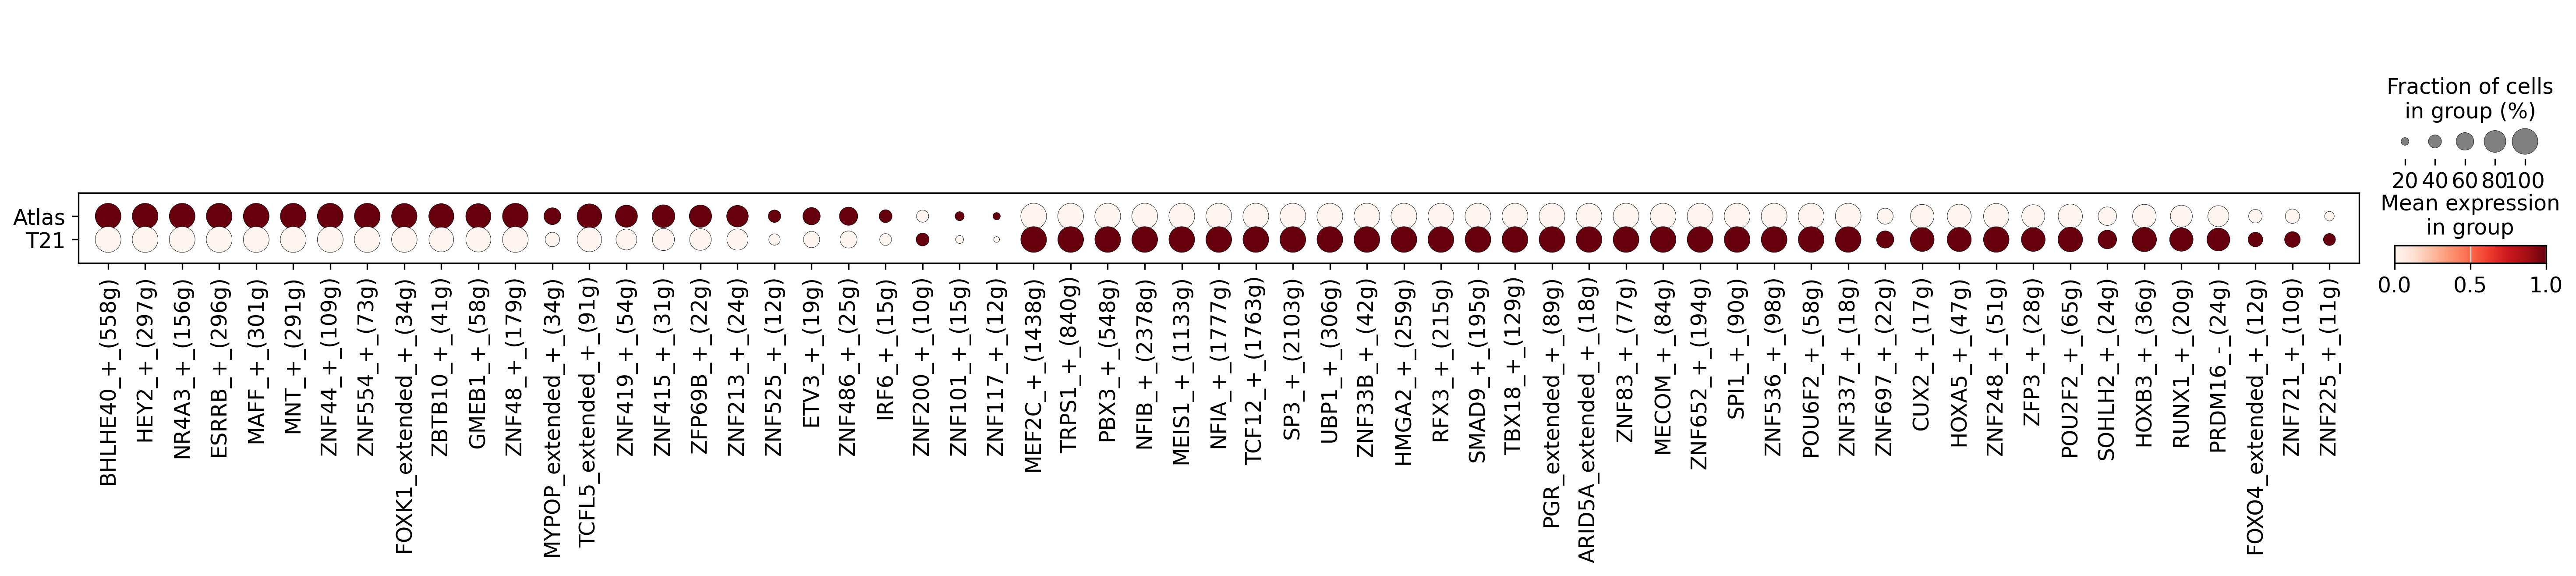

In [28]:
df = sc.get.rank_genes_groups_df(adata_reg_sub,
                            group=None,
                           pval_cutoff=0.1,
                           log2fc_min=0.2)

sc.pl.dotplot(adata_reg,
              df.names.unique(),
                                groupby='diagnosis',
                                dendrogram=False,
                               standard_scale='var'
             )

# Targets

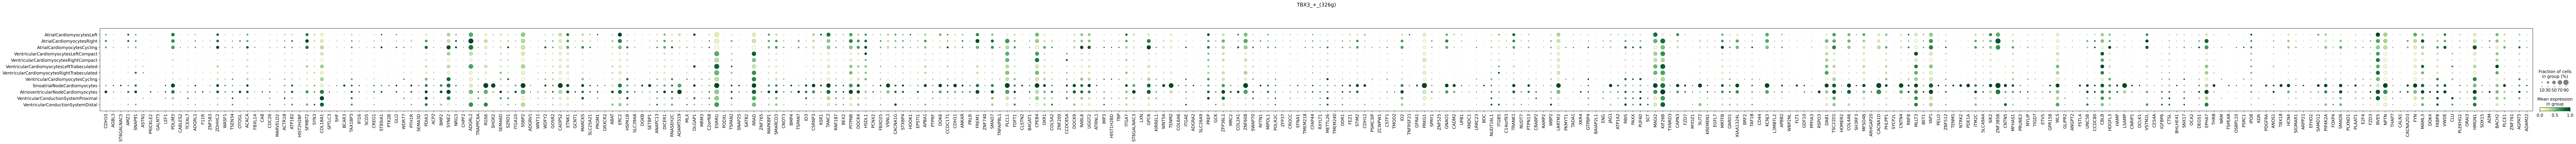

In [91]:
regulon_name = 'TBX3_+'

# get complete name
l = [x for x in eRegulon_signatures if regulon_name in x]
if len(l)==1: # should be 1
    regulon_name = l[0]
else:
    print('ERROR: zero or multiple regulons')
    print(l)

# get targets
target_names = eRegulon_signatures[regulon_name]

# plot
adata_filtered = adata.copy()
sc.pp.filter_genes(adata_filtered, min_cells=3)
sc.pl.dotplot(adata_filtered,
              target_names,
            groupby='fine_grain',
            dendrogram=False,
           standard_scale='var',
              cmap='YlGn',
             title=regulon_name)